In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from tqdm import tqdm
import torch
sys.path.append('../')
from plane import Plane
from propagator import PropagatorFactory

### CZT algorithm
The only change to allow for independent sampling of the input plane and the output plane is to replace the last calculation step $\mathbf{F}^{-1}\{U\}$ with a chirp z transform.

We need scaling factors $\alpha_x = \Delta x^z / \Delta {v_x}$, $\alpha_y = \Delta y^z / \Delta {v_y}$

We need new coordinates $w_x = \alpha_x v_x$, $w_y = \alpha_y v_y$

And therefore new sampling intervals $\Delta w_x = \Delta x = \alpha_x \Delta v_x$, $\Delta w_y = \Delta y = \alpha_y \Delta v_y$


The inverse fourier transform by the CZT is then

$$ u^z = \text{CZT}\{ U^z\} = \Delta w_x \Delta w_y C\left( \frac{U^z \cdot E}{\alpha_x \alpha_y} \circledast D \right) $$

where

$$ C = exp[j\pi(x^2/\alpha_x + y^2/\alpha_y)]$$

$$ D = exp[-j\pi(w_x^2/\alpha_x + w_y^2/\alpha_y)]$$

$$ E = exp[j\pi(w_x^2/\alpha_x + w_y^2/\alpha_y)]$$

and $\circledast$ is a linear convolution.

In [11]:
config = yaml.load(open('../config.yaml', 'r'), Loader=yaml.FullLoader)
plane1_params = {
    'name':'input_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':1080,
    'Ny':1080,
    'center': (0,0,0),
    'normal': (0,0,1)
}
plane2_params = {
    'name':'output_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':1080,
    'Ny':1080,
    'center': (0,0,9.e-2),
    'normal': (0,0,1)
}
plane1 = Plane(plane1_params)
plane2 = Plane(plane2_params)

2024-02-20 17:10:19.083 | DEBUG    | plane:__init__:8 - Initializing plane input_plane
2024-02-20 17:10:19.084 | DEBUG    | plane:fix_types:31 - Fixing types for plane input_plane
2024-02-20 17:10:19.086 | DEBUG    | plane:create_rotation_matrix:86 - Creating rotation matrix
2024-02-20 17:10:19.087 | DEBUG    | plane:create_rotation_matrix:99 - Input and output plane normals are the same.
2024-02-20 17:10:19.087 | DEBUG    | plane:build_plane:41 - Building plane input_plane
2024-02-20 17:10:19.088 | DEBUG    | plane:__init__:8 - Initializing plane output_plane
2024-02-20 17:10:19.089 | DEBUG    | plane:fix_types:31 - Fixing types for plane output_plane
2024-02-20 17:10:19.090 | DEBUG    | plane:create_rotation_matrix:86 - Creating rotation matrix
2024-02-20 17:10:19.091 | DEBUG    | plane:create_rotation_matrix:99 - Input and output plane normals are the same.
2024-02-20 17:10:19.092 | DEBUG    | plane:build_plane:41 - Building plane output_plane


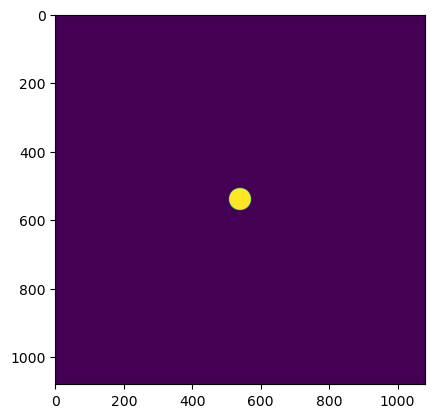

In [12]:
U = torch.ones((plane1.Nx, plane1.Ny))
mask = np.sqrt(plane1.xx**2 + plane1.yy**2) < 0.15e-3
U = U * mask
plt.imshow(U)

In [13]:
pf = PropagatorFactory()
config['propagator']['prop_type'] = None
prop = pf(plane1, plane2, config['propagator'])

2024-02-20 17:10:19.738 | DEBUG    | propagator:select_propagator:21 - Selecting propagator
2024-02-20 17:10:19.740 | DEBUG    | propagator:check_asm_distance:149 - Checking ASM propagation criteria
2024-02-20 17:10:19.741 | DEBUG    | propagator:check_asm_distance:162 - Axial distance between input and output planes: 0.09000000357627869
2024-02-20 17:10:19.743 | DEBUG    | propagator:check_asm_distance:171 - Maximum axial distance for asm : 0.029925363138318062
2024-02-20 17:10:19.744 | DEBUG    | propagator:select_propagator:86 - Using RSC propagator
2024-02-20 17:10:19.745 | DEBUG    | propagator:init_rsc_transfer_function:217 - Initializing RSC transfer function


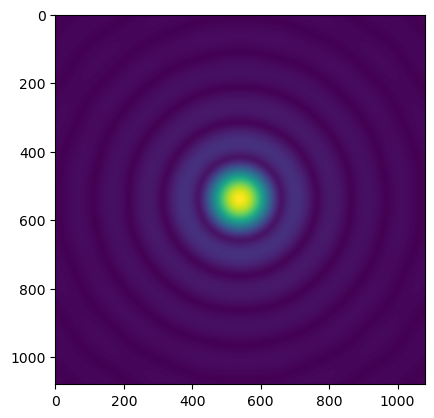

In [14]:
output = prop(U)
plt.imshow(output.abs())